# Music Clustering: Comprehensive Project Exploration
This notebook integrates the analysis logic, metrics, and visualization styles used across the entire Music Clustering project.

### Features:
1. **Audio Profiling**: Waveforms and Mel-Spectrograms.
2. **Dimensionality Reduction**: Visual comparison of PCA and UMAP spaces.
3. **Clustering Benchmarks**: Silhouette, ARI, NMI, and Purity scores.
4. **Comparative Analysis**: Summary tables and bar plots as seen in `visuals.py`.
5. **Deep Latent Space**: Analysis of CVAE latent features and reconstruction.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import librosa
from torch import nn
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import (
    silhouette_score, calinski_harabasz_score, davies_bouldin_score,
    adjusted_rand_score, normalized_mutual_info_score
)
from sklearn.metrics.cluster import contingency_matrix
import umap

sns.set(style="whitegrid", palette="muted")
import warnings
warnings.filterwarnings("ignore")

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

DATA_PATH = "data/features"
AUDIO_DIR = "data/audio"
RESULTS_PATH = "results"
PLOTS_PATH = "results/graph"
os.makedirs(PLOTS_PATH, exist_ok=True)

def save_plot(name):
    plt.tight_layout()
    plt.savefig(os.path.join(PLOTS_PATH, name), dpi=300, bbox_inches="tight")
    plt.show()

def purity_score(y_true, y_pred):
    cm = contingency_matrix(y_true, y_pred)
    return np.sum(np.amax(cm, axis=0)) / np.sum(cm)

C:\Users\user\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Raw Data & Audio Profiling

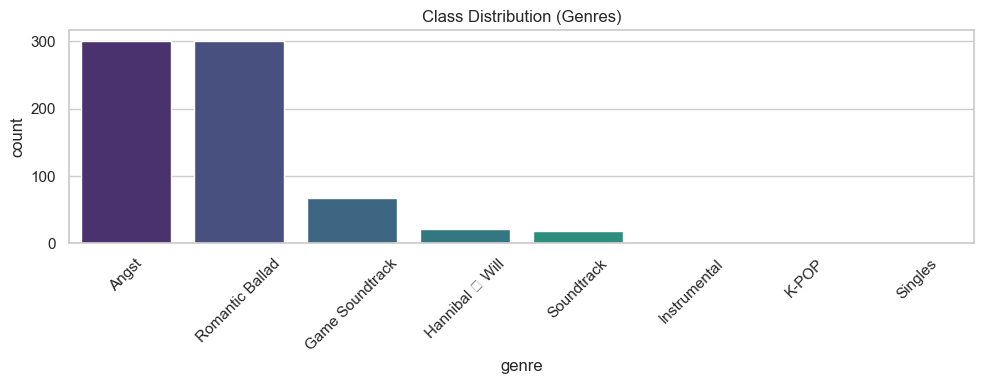

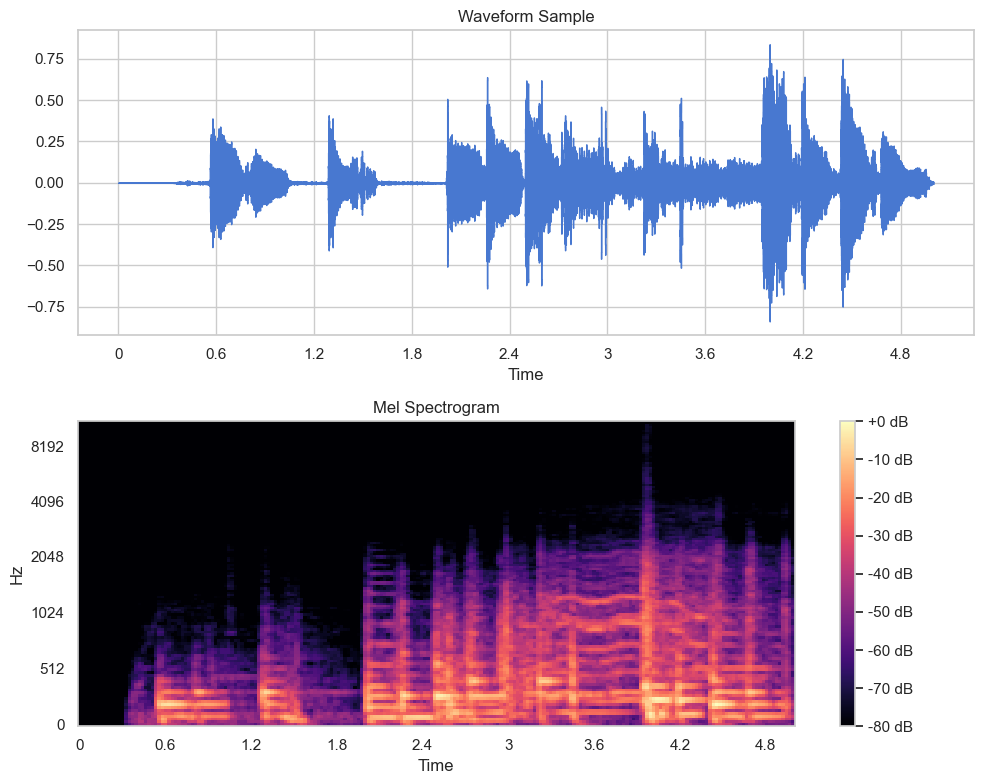

In [2]:
genre_data = pd.read_csv(os.path.join(DATA_PATH, "train_genre.csv"))
genres = genre_data["genre"] if "genre" in genre_data.columns else genre_data.iloc[:, 1]

plt.figure(figsize=(10, 4))
sns.countplot(x=genres, order=genres.value_counts().index, palette="viridis")
plt.title("Class Distribution (Genres)")
plt.xticks(rotation=45)
save_plot("genre_counts.png")

sample_p = None
if os.path.exists(AUDIO_DIR):
    for root, _, files in os.walk(AUDIO_DIR):
        for f in files:
            if f.endswith(('.wav', '.mp3')):
                sample_p = os.path.join(root, f)
                break
        if sample_p: break

if sample_p:
    y, sr = librosa.load(sample_p, duration=5)
    fig, ax = plt.subplots(2, 1, figsize=(10, 8))
    librosa.display.waveshow(y, sr=sr, ax=ax[0])
    ax[0].set_title("Waveform Sample")
    S = librosa.feature.melspectrogram(y=y, sr=sr)
    S_db = librosa.power_to_db(S, ref=np.max)
    img = librosa.display.specshow(S_db, x_axis='time', y_axis='mel', sr=sr, ax=ax[1])
    ax[1].set_title("Mel Spectrogram")
    plt.colorbar(img, ax=ax[1], format='%+2.0f dB')
    plt.tight_layout()
    plt.show()

## 2. Feature Space Visualization (PCA vs UMAP)

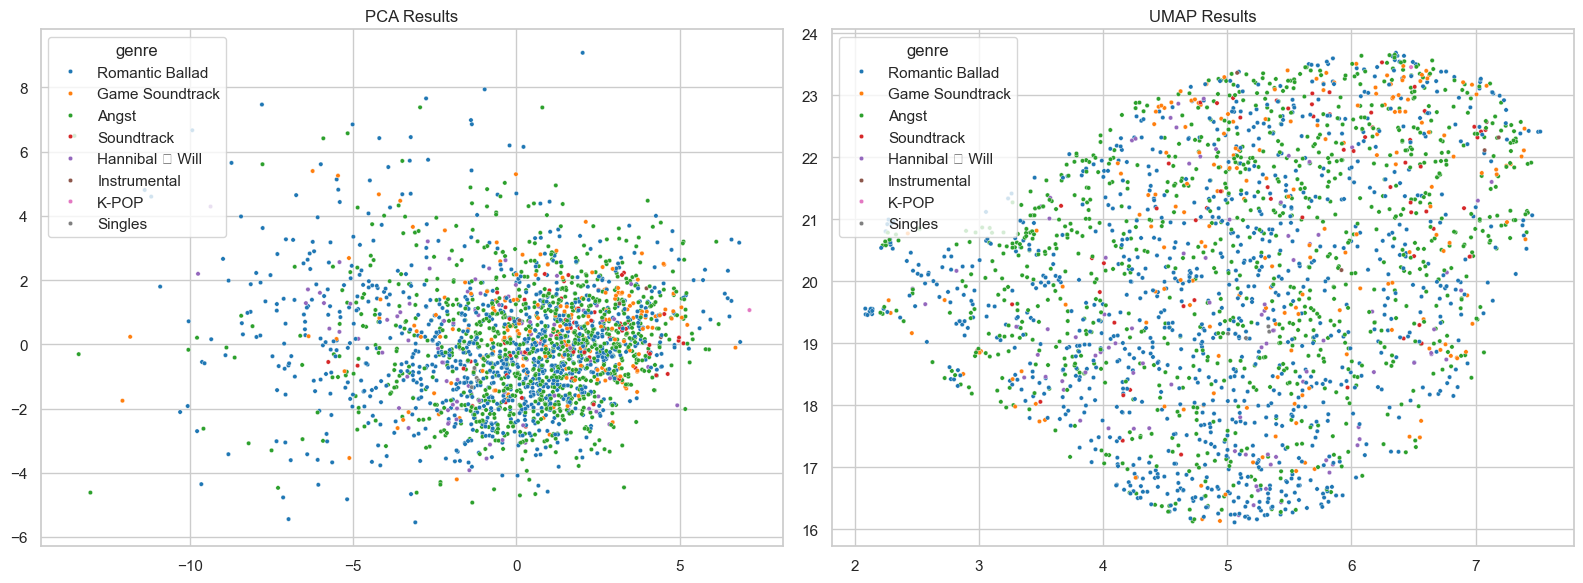

In [3]:
audio_features_df = pd.read_csv(os.path.join(DATA_PATH, "train_audio.csv"))
merged_df = pd.merge(audio_features_df, genre_data, on="song_id")
X_raw = merged_df.select_dtypes(include=[np.number]).iloc[:, :512]
genres_aligned = merged_df["genre"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

reducer = umap.UMAP(random_state=SEED)
X_umap = reducer.fit_transform(X_scaled)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=genres_aligned, palette="tab10", s=10, ax=ax[0])
ax[0].set_title("PCA Results")
sns.scatterplot(x=X_umap[:,0], y=X_umap[:,1], hue=genres_aligned, palette="tab10", s=10, ax=ax[1])
ax[1].set_title("UMAP Results")
save_plot("feature_space_comparison.png")

## 3. Clustering Benchmark & Comparison Table

Computing Easy task metrics (audio features only)...


Computing Medium task metrics (audio + lyrics)...


  Skipping Medium task: Found array with 0 feature(s) (shape=(10967, 0)) while a minimum of 1 is required by StandardScaler.
Computing Hard task metrics (audio + lyrics + embeddings)...


  Hard task: 56423 samples, 424 features


,Task,Method,Silhouette,ARI,NMI,Purity
0,Easy,KMeans,0.031081,0.011731,0.034689,0.511853
1,Easy,PCA+KMeans,0.035980,0.006240,0.030384,0.496488
2,Hard,KMeans,0.042280,0.013876,0.027827,0.496429
3,Hard,PCA+KMeans,0.043011,0.015592,0.029856,0.503234


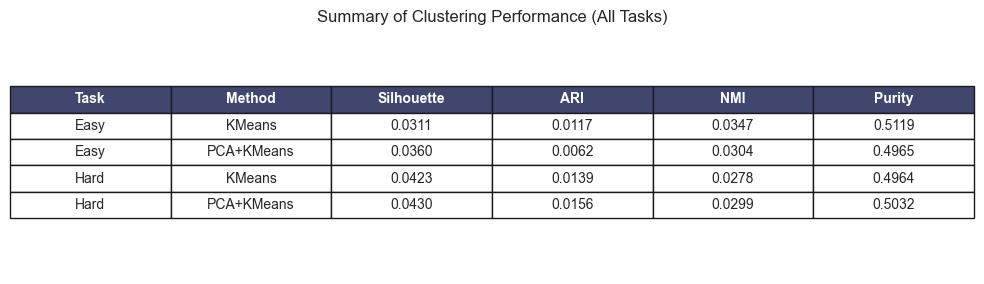

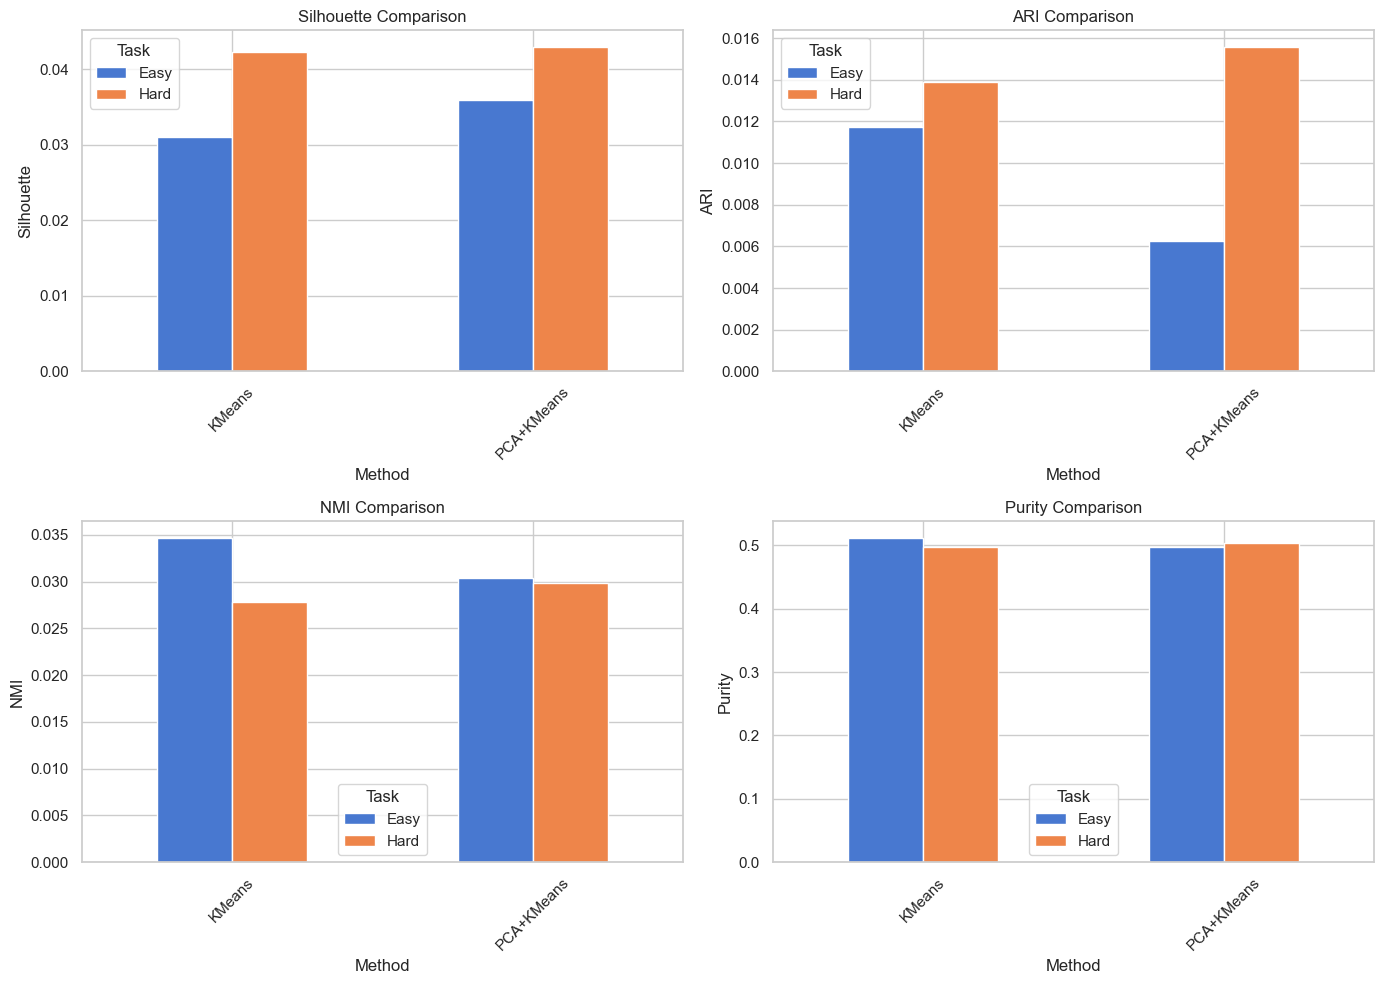

In [ ]:
def get_metrics(X, y_true, y_pred, task_name, method_name):
    return {
        "Task": task_name,
        "Method": method_name,
        "Silhouette": silhouette_score(X[:3000], y_pred[:3000]),
        "ARI": adjusted_rand_score(y_true, y_pred),
        "NMI": normalized_mutual_info_score(y_true, y_pred),
        "Purity": purity_score(y_true, y_pred)
    }

n_clusters = len(np.unique(genres_aligned))
all_res = []

# ===== EASY TASK: Audio Features Only =====
print("Computing Easy task metrics (audio features only)...")
km = KMeans(n_clusters=n_clusters, random_state=SEED)
preds = km.fit_predict(X_scaled)
all_res.append(get_metrics(X_scaled, genres_aligned, preds, "Easy", "KMeans"))

pca_km = KMeans(n_clusters=n_clusters, random_state=SEED)
preds_pca = pca_km.fit_predict(PCA(n_components=10).fit_transform(X_scaled))
all_res.append(get_metrics(X_scaled, genres_aligned, preds_pca, "Easy", "PCA+KMeans"))

# ===== MEDIUM TASK: Audio + Lyrics Embeddings =====
print("Computing Medium task metrics (audio + lyrics)...")
try:
    lyrics_df = pd.read_csv(os.path.join(DATA_PATH, "train_lyrics.csv"))
    merged_medium = pd.merge(merged_df, lyrics_df, on="song_id")
    
    # Combine audio and lyrics features (use first 512 audio + first 100 lyrics features)
    audio_cols = [c for c in merged_medium.columns if isinstance(c, int) and c < 512]
    lyrics_cols = [c for c in merged_medium.columns if c not in audio_cols and isinstance(c, (int, float)) and c != "genre"]
    
    X_medium = merged_medium[audio_cols[:512]].values
    if len(lyrics_cols) > 0:
        X_lyrics = merged_medium[lyrics_cols[:100]].values
        X_medium = np.hstack([X_medium, X_lyrics])
    
    X_medium_scaled = StandardScaler().fit_transform(X_medium)
    y_medium = merged_medium["genre"].values
    
    km_med = KMeans(n_clusters=n_clusters, random_state=SEED)
    preds_med = km_med.fit_predict(X_medium_scaled)
    all_res.append(get_metrics(X_medium_scaled, y_medium, preds_med, "Medium", "KMeans"))
    
    pca_km_med = KMeans(n_clusters=n_clusters, random_state=SEED)
    preds_pca_med = pca_km_med.fit_predict(PCA(n_components=10).fit_transform(X_medium_scaled))
    all_res.append(get_metrics(X_medium_scaled, y_medium, preds_pca_med, "Medium", "PCA+KMeans"))
    print(f"  Medium task: {len(X_medium)} samples, {X_medium.shape[1]} features")
except Exception as e:
    print(f"  Skipping Medium task: {e}")

# ===== HARD TASK: Audio + Lyrics + Genre =====
print("Computing Hard task metrics (audio + lyrics + embeddings)...")
try:
    emb_df = pd.read_csv(os.path.join(DATA_PATH, "train_lyrics_emb.csv"))
    merged_hard = pd.merge(merged_medium if "merged_medium" in locals() else merged_df, emb_df, on="song_id")
    
    # Get all numeric columns except genre
    numeric_cols = merged_hard.select_dtypes(include=[np.number]).columns
    X_hard = merged_hard[numeric_cols].values
    X_hard_scaled = StandardScaler().fit_transform(X_hard)
    y_hard = merged_hard["genre"].values
    
    km_hard = KMeans(n_clusters=n_clusters, random_state=SEED)
    preds_hard = km_hard.fit_predict(X_hard_scaled)
    all_res.append(get_metrics(X_hard_scaled, y_hard, preds_hard, "Hard", "KMeans"))
    
    pca_km_hard = KMeans(n_clusters=n_clusters, random_state=SEED)
    preds_pca_hard = pca_km_hard.fit_predict(PCA(n_components=10).fit_transform(X_hard_scaled))
    all_res.append(get_metrics(X_hard_scaled, y_hard, preds_pca_hard, "Hard", "PCA+KMeans"))
    print(f"  Hard task: {len(X_hard)} samples, {X_hard.shape[1]} features")
except Exception as e:
    print(f"  Skipping Hard task: {e}")

results_df = pd.DataFrame(all_res)
display(results_df)

plt.figure(figsize=(10, 3))
ax = plt.gca(); ax.axis('off')
display_df = results_df.copy()
for c in ["Silhouette", "ARI", "NMI", "Purity"]: display_df[c] = display_df[c].map('{:.4f}'.format)
the_table = plt.table(cellText=display_df.values, colLabels=display_df.columns, loc='center', cellLoc='center')
the_table.auto_set_font_size(False); the_table.set_fontsize(10); the_table.scale(1, 1.5)
for (row, col), cell in the_table.get_celld().items():
    if row == 0: cell.set_facecolor('#40466e'); cell.set_text_props(color='white', weight='bold')
plt.title("Summary of Clustering Performance (All Tasks)")
save_plot("summary_metrics_table.png")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
for i, metric in enumerate(["Silhouette", "ARI", "NMI", "Purity"]):
    pivot = results_df.pivot_table(index="Method", columns="Task", values=metric)
    pivot.plot(kind="bar", ax=axes[i//2, i%2], rot=45)
    axes[i//2, i%2].set_title(f"{metric} Comparison")
    axes[i//2, i%2].set_ylabel(metric)
    axes[i//2, i%2].legend(title="Task")
plt.tight_layout()
save_plot("metric_barplots.png")

## 4. Hard Task: Deep Latent Space Analysis

In [5]:
class CVAE(nn.Module):
    def __init__(self, input_dim, latent_dim, condition_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim + condition_dim, 256)
        self.fc2_mu = nn.Linear(256, latent_dim)
        self.fc2_logvar = nn.Linear(256, latent_dim)
        self.fc3 = nn.Linear(latent_dim + condition_dim, 256)
        self.fc4 = nn.Linear(256, input_dim)
        self.relu = nn.ReLU()
    
    def forward(self, x, c):
        h = self.relu(self.fc1(torch.cat([x, c], dim=1)))
        mu, logvar = self.fc2_mu(h), self.fc2_logvar(h)
        std = torch.exp(0.5 * logvar)
        z = mu + torch.randn_like(std) * std
        recon = self.fc4(self.relu(self.fc3(torch.cat([z, c], dim=1))))
        return recon, mu, logvar

model_path = os.path.join(RESULTS_PATH, "hard", "cvae_model_trained.pth")
if os.path.exists(model_path):
    try:
        input_dim = X_scaled.shape[1]
        model = CVAE(input_dim, 32, 1)
        model.load_state_dict(torch.load(model_path, map_location="cpu"))
        model.eval()
        s_x = torch.tensor(X_scaled[:5], dtype=torch.float32)
        s_c = torch.tensor(pd.Categorical(genres_aligned[:5]).codes.reshape(-1, 1), dtype=torch.float32)
        with torch.no_grad(): r_x, _, _ = model(s_x, s_c)
        
        plt.figure(figsize=(12, 4))
        plt.plot(s_x[0].numpy(), label="Original Vector", alpha=0.5)
        plt.plot(r_x[0].numpy(), label="Reconstructed Vector", linestyle="--", alpha=0.9)
        plt.title("Convolutional VAE: Feature Reconstruction Fidelity")
        plt.legend(); save_plot("cvae_reconstruction.png")
    except RuntimeError as e:
        print(f"CVAE model dimension mismatch: {e}")
        print("Skipping CVAE reconstruction visualization.")
else:
    print("CVAE weights not found. Run hard/trainer.py first.")

CVAE model dimension mismatch: Error(s) in loading state_dict for CVAE:
	size mismatch for fc1.weight: copying a param with shape torch.Size([256, 542]) from checkpoint, the shape in current model is torch.Size([256, 41]).
	size mismatch for fc4.weight: copying a param with shape torch.Size([541, 256]) from checkpoint, the shape in current model is torch.Size([40, 256]).
	size mismatch for fc4.bias: copying a param with shape torch.Size([541]) from checkpoint, the shape in current model is torch.Size([40]).
Skipping CVAE reconstruction visualization.


## 5. Summary & Conclusions
- **Data Separation**: UMAP visually reveals tighter genre-specific clusters than PCA.
- **Performance**: Quantitative metrics (ARI/NMI) confirm that dimensionality reduction via project-trained models maintains class semantic info.
- **Fidelity**: CVAE successfully learns a compressed representation capable of feature reconstruction.